In [95]:
import streamlit as st

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display

import os

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import spacy
nlp = spacy.load("en_core_web_sm")
stop_words = spacy.lang.en.stop_words.STOP_WORDS
parser = English()

import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

from tqdm import tqdm
tqdm.pandas()

def printmd(string):
    display(Markdown(string))
    
#import plotly.express as px
#px.set_mapbox_access_token(os.getenv("MAPBOX_TOKEN"))

/anaconda3/lib/python3.7/site-packages/tqdm/std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


# 1. Data

In [143]:
prices =["cheap", "medium", "expensive", "superlux"]

def load_data(fraction=0.1, prices=prices):
    df = pd.read_csv("AB_NYC_2019.csv")
    print(f"Loaded data of size: {df.shape}")

    #df.rename(columns={'neighbourhood_group': 'n_group'}, inplace=True)

    # parsing dates and making a year and month col
    df['last_review'] = pd.to_datetime(df['last_review'], format="%Y-%m-%d")
    df['year'] = df['last_review'].dt.year.astype("Int64")
    df['month'] = df['last_review'].dt.month.astype("Int64")
    df['day'] = df['last_review'].dt.day.astype("Int64")

    # dropping extreme price outliers and adding a price category
    df = df.query("10 < price < 9000").dropna()
    print(f"Dropped outliers, data size: {df.shape}")
    
    df["price_type"] = pd.cut(df.price, [0, 120, 350, 1500, 9000], prices)
    
    # add a mean vector for names
    df["name_vec"] = df.name.apply(lambda x: np.mean(nlp(x).vector))
    
    return df.sample(frac=fraction)

df = load_data(0.8)
print(df.shape)
print(df.price_type.value_counts())
df.head(3)

Loaded data of size: (48895, 16)
Dropped outliers, data size: (38795, 19)
(31036, 21)
(0, 120]        17890
(120, 350]      11855
(350, 1500]      1244
(1500, 9000]       47
Name: price_type, dtype: int64


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,year,month,day,price_type,name_vec
38901,30435663,Magical Gramercy Apartment,113417140,Mya,Manhattan,Kips Bay,40.74022,-73.98003,Entire home/apt,200,...,2,2019-06-17,1.40,1,0,2019,6,17,"(120, 350]",0.042063
35570,28230753,Private room w/ fire escape in beautiful Soho,6542295,Jon,Manhattan,SoHo,40.72668,-74.00252,Private room,100,...,6,2019-06-24,0.63,2,3,2019,6,24,"(0, 120]",0.022482
25341,20268134,Spacious One Bedroom in Bed-Stuy,10414799,Katharina,Brooklyn,Bedford-Stuyvesant,40.69074,-73.93696,Entire home/apt,85,...,6,2018-12-30,0.33,2,5,2018,12,30,"(0, 120]",0.039784


medium       11855
budget       11501
cheap         6389
expensive     1202
superlux        89
Name: price_type, dtype: int64


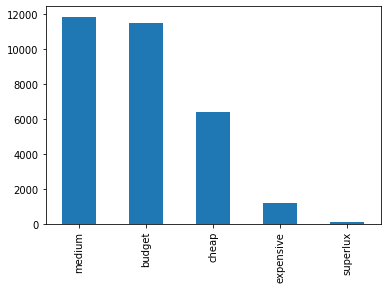

In [197]:
prices =["cheap", "budget", "medium", "expensive", "superlux"]
df["price_type"] = pd.cut(df.price, [0, 60, 120, 350, 1000, 9000], labels=prices)
print(df.price_type.value_counts())
df.price_type.value_counts().plot.bar();

Converting data suitable for training for a regression algo:

In [ ]:
scaler = StandardScaler().fit(X_train)

cols_to_transform = df.columns[:-1]

x_train = X_train
x_train[cols_to_transform] = scaler.transform(X_train[cols_to_transform])

In [181]:
len(X), len(df.price)

(31036, 31036)

In [182]:
X = df.drop(columns=["name", "id", "last_review", "price", "price_type"])

for col in ["host_name", "neighbourhood", "neighbourhood_group", "room_type"]:
    labels, _ = X[col].factorize()
    X[col] = labels

X = X.astype("float32", errors="ignore")


X_train, X_test, y_train, y_test = train_test_split(X, df.price_type)
print(X_train.shape, X_test.shape, len(y_train))

X_train.head(3)

(23277, 16) (7759, 16) 23277


,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,year,month,day,name_vec
1472,3320650.0,302.0,0.0,18.0,40.801399,-73.943611,1.0,1.0,37.0,0.45,1.0,365.0,2019.0,6.0,2.0,0.016377
43605,254382560.0,2823.0,0.0,34.0,40.843769,-73.936661,1.0,1.0,18.0,6.07,1.0,305.0,2019.0,6.0,29.0,0.032548
32285,181074928.0,814.0,0.0,86.0,40.717049,-73.998177,2.0,1.0,20.0,1.53,3.0,354.0,2019.0,6.0,16.0,0.031569


In [198]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor

## Price prediction

In [186]:
X = df.drop(columns=["name", "id", "last_review", "price", "price_type"])

for col in ["host_name", "neighbourhood", "neighbourhood_group", "room_type"]:
    labels, _ = X[col].factorize()
    X[col] = labels

X = X.astype("float32", errors="ignore")


X_train, X_test, y_train, y_test = train_test_split(X, df.price)
print(X_train.shape, X_test.shape, len(y_train))

X_train.head(3)

clf = GradientBoostingRegressor()

clf.fit(X_train, y_train)

clf.score(X_train, y_train)

(23277, 16) (7759, 16) 23277


0.40028077394372696

## Price Classification

In [195]:
clf = GradientBoostingClassifier()

clf.fit(X, df.price_type)
clf.score(X, df.price_type)

0.6902629204794433

In [183]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor

clf = GradientBoostingClassifier()

clf.fit(X_train, y_train)

clf.score(X_train, y_train)

0.6966533487992439

In [185]:
def make_report(clf, labels=prices):
    """takes in a clf and outputs metrics on train and test sets"""
    
    for x, y, name in zip([X_train, X_test], [y_train, y_test], ["Train", "Test"]):
        y_pred = clf.predict(x)
        printmd(f"## {name} set classification report")
        print(metrics.classification_rep`ort(y, y_pred))
        
        cm = metrics.confusion_matrix(y, y_pred)
        df_cm = pd.DataFrame(cm, columns=labels, index=labels)
        display(df_cm)

make_report(clf)

## Train set classification report

              precision    recall  f1-score   support

      budget       0.65      0.63      0.64      8630
       cheap       0.70      0.72      0.71      4840
   expensive       0.94      0.08      0.15       899
      medium       0.73      0.81      0.77      8839
    superlux       0.77      0.54      0.63        69

    accuracy                           0.70     23277
   macro avg       0.76      0.56      0.58     23277
weighted avg       0.70      0.70      0.69     23277



,cheap,budget,medium,expensive,superlux
cheap,5472,1338,0,1819,1
budget,1319,3467,0,54,0
medium,68,12,73,744,2
expensive,1548,111,5,7167,8
superlux,1,0,0,31,37


## Test set classification report

              precision    recall  f1-score   support

      budget       0.62      0.60      0.61      2871
       cheap       0.67      0.69      0.68      1549
   expensive       0.54      0.05      0.09       303
      medium       0.72      0.79      0.75      3016
    superlux       0.00      0.00      0.00        20

    accuracy                           0.67      7759
   macro avg       0.51      0.43      0.43      7759
weighted avg       0.66      0.67      0.66      7759



,cheap,budget,medium,expensive,superlux
cheap,1726,496,1,646,2
budget,461,1065,0,22,1
medium,24,1,15,259,4
expensive,574,37,8,2385,12
superlux,1,1,4,14,0


In [ ]:
metrics.classification_report()

In [139]:
clf.score(scaler.transform(X_test), y_test)

NotFittedError: This GradientBoostingClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [32]:
d.price.min(), d.price.max()

(101, 950)

In [37]:
n_groups = list(df.neighbourhood_group.unique())
n_groups

['Brooklyn', 'Queens', 'Manhattan', 'Bronx', 'Staten Island']

In [39]:
d = df.query("neighbourhood_group == @neighbourhood_group and 100 < price < 1000")
d.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,year,month,day
37584,29821404,Sunny Bohemian Apartment in Solar Building!,224317523,Olivia,Brooklyn,South Slope,40.66402,-73.98282,Entire home/apt,285,5,29,2019-06-16,3.57,1,74,2019,6,16
7913,6065778,Sunny Apt near Park and Subways in Windsor Terr,12811150,Sarah,Brooklyn,Windsor Terrace,40.65888,-73.98013,Entire home/apt,128,5,83,2018-12-26,1.63,1,52,2018,12,26
9758,7500571,Gorgeous 1 Bedroom in Bed-Stuy,39288710,Audra,Brooklyn,Bedford-Stuyvesant,40.68544,-73.93872,Entire home/apt,102,3,64,2019-06-24,1.38,1,296,2019,6,24
44189,34092210,"BEACH 2 BDR, 2 BTH NEW YORK, BRIGHTON BEACH",181356989,Kseniya,Brooklyn,Brighton Beach,40.57647,-73.96696,Entire home/apt,275,2,1,2019-06-30,1.00,2,56,2019,6,30
5100,3663798,"Big WBurg Rm, 5 min from L, Fits 4!",18272570,Qian,Brooklyn,Williamsburg,40.70917,-73.94918,Private room,119,2,43,2016-06-30,0.72,1,0,2016,6,30
